# Продвинутый Python, лекция 4

**Лектор:** Петров Тимур

**Семинаристы:** Дешулин Олег, Коган Александра, Васина Олеся, Садуллаев Музаффар, Бузаев Федор

**Spoiler Alert:** в рамках курса нельзя изучить ни одну из тем от и до досконально (к сожалению, на это требуется больше времени, чем даже 3 часа в неделю). Но мы попробуем рассказать столько, сколько возможно :)

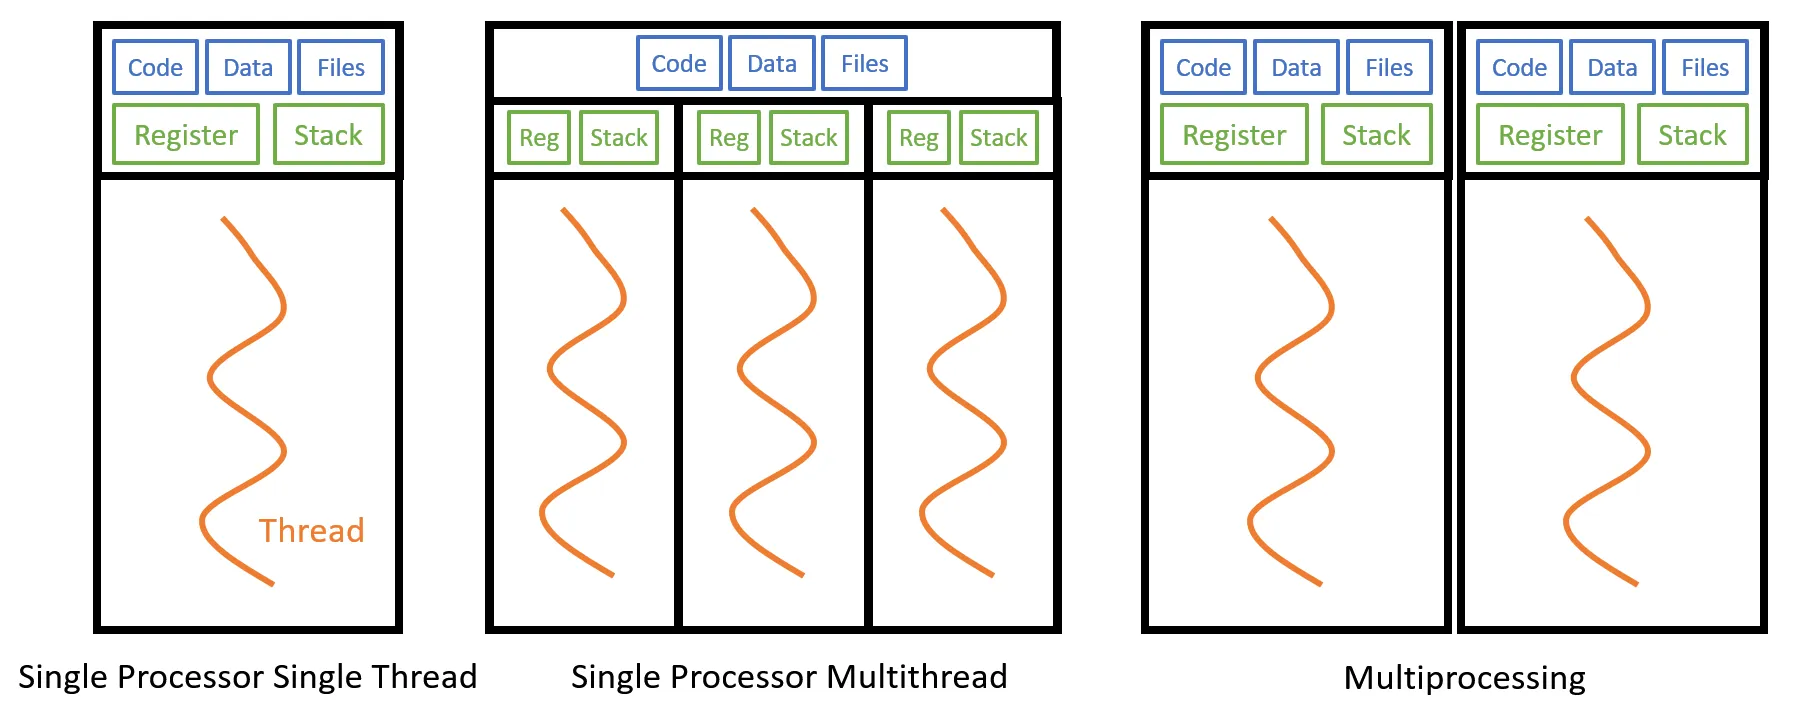
[click for source](https://towardsdatascience.com/multithreading-and-multiprocessing-in-10-minutes-20d9b3c6a867#:~:text=By%20formal%20definition%2C%20multithreading%20refers,run%20one%20or%20more%20threads)


Давайте порассматриваем картинку!

Слева: обычная жизнь обычного человека, то как мы привыкли думать про код, в котором ничего не запускается параллельно.

В середине: многопоточная программа, видно что у каждого потока (thread) свой набор каких-то переменных (registry) и stack исполения. При этом они все живут внутри одного python (code) - одного большого процесса.

Справа: Multiprocessing. Видно, что процесс - это инстанс программы, где у вас есть выполняемый код и собственные ресурсы памяти, по сути все тож самое что и на первой картинке. У каждого процесса прямой доступ есть только к своим ресурсам.

При этом что важно понимать, в программе может быть как много процессов, внутри каждого процесса еще и много потоков, а внутри каждого потока еще и асинхронный код.. (к этому вернемся позже)


# Процессы

### psutils (Смотрим на процессы)

In [ ]:
!ps #Выводим все процессы

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      6 ?        00:00:00 node
     15 ?        00:00:00 oom_monitor.sh
     17 ?        00:00:00 run.sh
     20 ?        00:00:00 kernel_manager_
     37 ?        00:00:00 tail
     43 ?        00:00:00 tail
     70 ?        00:00:07 python3 <defunct>
     71 ?        00:00:00 colab-fileshim.
     88 ?        00:00:04 jupyter-noteboo
     89 ?        00:00:00 dap_multiplexer
    401 ?        00:00:02 python3
    440 ?        00:00:00 python3
    472 ?        00:00:00 language_servic
    478 ?        00:00:03 node
    508 ?        00:00:00 sleep
    511 ?        00:00:00 ps


Процессы запущенные рутом:

In [ ]:
!ps -U root #Выбираем процессы, запущенные от конкретного пользователя (флаг -U = user)

    PID TTY          TIME CMD
      1 ?        00:00:00 docker-init
      6 ?        00:00:00 node
     15 ?        00:00:00 oom_monitor.sh
     17 ?        00:00:00 run.sh
     20 ?        00:00:00 kernel_manager_
     37 ?        00:00:00 tail
     43 ?        00:00:00 tail
     70 ?        00:00:07 python3 <defunct>
     71 ?        00:00:00 colab-fileshim.
     88 ?        00:00:04 jupyter-noteboo
     89 ?        00:00:00 dap_multiplexer
    401 ?        00:00:02 python3
    440 ?        00:00:00 python3
    472 ?        00:00:00 language_servic
    478 ?        00:00:05 node
    536 ?        00:00:00 sleep
    537 ?        00:00:00 ps


Воспользуемся встроенной библиотекой [psutil](https://psutil.readthedocs.io/en/latest/index.html) чтобы сделать тоже самое (это нам еще понадобится):

In [ ]:
import psutil

def list_all_processes():
    print("Listing current processes:")
    for proc in psutil.process_iter(['pid', 'name']):
        try:
            print(f"PID: {proc.info['pid']}, process name: {proc.info['name']}")
        except psutil.NoSuchProcess:
            pass

In [ ]:
list_all_processes()

Listing current processes:
PID: 1, process name: docker-init
PID: 6, process name: node
PID: 15, process name: oom_monitor.sh
PID: 17, process name: run.sh
PID: 20, process name: kernel_manager_proxy
PID: 37, process name: tail
PID: 43, process name: tail
PID: 70, process name: python3
PID: 71, process name: colab-fileshim.
PID: 88, process name: jupyter-noteboo
PID: 89, process name: dap_multiplexer
PID: 401, process name: python3
PID: 440, process name: python3
PID: 12832, process name: sleep


Давайте научимся создавать процесс сами!

С помощью библиотеки multiprocessing:

Библиотека [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) позволяет организовать параллелизм вычислений за счет создания подпроцессов. Каждый процесс выполняется независимо от других!

В данном случае внутри процесса создаем подпроцессы (дробим процесс, то есть и память и все остальное). И в этом смысле мы реально делим на ядра (каждое ядро выполняет свою часть). Разбивая процесс на подпроцессы мы создаем отдельно интерпретаторы для каждой части, которые выполняются независимо (такая реальная параллельность), но при этом они могут друг с другом перекидываться данными

Число процессов ограничивается число ядер (на самом деле нет, но смысла от числа процессор, большего, чем кол-во ядер, просто нет). Как узнать число ядер:

In [ ]:
import multiprocessing as mp

In [ ]:
print(mp.cpu_count()) # у нас всего 2 ядра

2


Давайте создавать различные процессы!

In [ ]:
def f(x):
    return x ** 2

with mp.Pool() as pool:
    result = pool.map(f, range(10)) # аналог функции map, только для процессов
result

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

Ура, мы возвели в степень в отдельном процессе! Однако пока толка мало: мы создали 1 процесс, в нем все сделали и вернули, ничего примерно не дает нам

Кроме синтаксиса map, можно же сделать start / join руками (отдельно выделяем сам процесс, запихиваем его для выполнения):

In [ ]:
result = []

def f():
    result.append("Hi")

processes = [mp.Process(target=f) for _ in range(2)]
for p in processes: # Запускаем каждый процесс отдельно
    p.start()
for p in processes: # Собираем результаты из каждого процесса отдельно
    p.join()
print(result)

[]


А чего это ничего не получилось? Потому что каждый процесс - это процесс (соответственно, своя память, свои локальные переменные, обмена никакого нет, получаем пустоту)

Когда мы воспользовались штукой Pool() выше, то она создала связанный набор воркеров, которые обмениваются друг с другом данными и полученными результатами. Давайте на примере, как можно распараллелить какое-нибудь вычисление:

In [ ]:
arr = [i for i in range(10**7)]

In [ ]:
size = len(arr)
process_count = mp.cpu_count()
part_size = size // process_count
array_parts = [
    arr[i * part_size: (i + 1) * part_size]
    for i in range(process_count)
]

In [ ]:
%%timeit -n 2 -r 3

sum(arr[i] for i in range(len(arr)))

989 ms ± 277 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [ ]:
%%timeit -n 2 -r 3

with mp.Pool(process_count) as pool:
    result = pool.map(sum, array_parts)

1.21 s ± 28.6 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


Что видим? Видим, что времени у нас затратилось побольше, чем прямое вычисление. Почему оно так? Банально потому что выделение ресурсов - дело дорогое (но к этому мы еще вернемся)

### Subprocess и pipe

Хорошо, а как налаживать взаимоотношения между процессами самим, без использования Poolов?

Здесь помогут средства библиотечки subprocess и так называемые pipe - трубы между процессами, которые можно прокидывать. Обратите внимание, что у вас есть полная свобода как именно провести трубы и что с чем соединить!

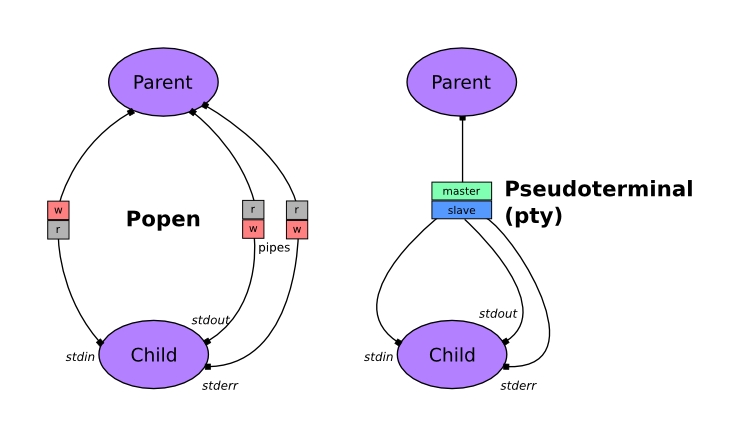

Хорошо, но кстати, никто не обещал, что subprocess обязательно на питоне, что если хочется запустить какой-то процесс.. и это не python. (формально - процесс может выполняться чем угодно, хоть код на плюсах из питона вызывайте)

In [ ]:
import subprocess
import io

In [ ]:
result = subprocess.run("ls -l", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) #запустили отдельный подпроцесс внутри программы
print(result)
print(result.stdout)
print('-' * 30)
print(result.stderr)

CompletedProcess(args='ls -l', returncode=0, stdout='total 12\n-rw-r--r-- 1 root root  360 Sep 29 11:36 calculator.py\ndrwxr-xr-x 1 root root 4096 Sep 25 18:24 sample_data\n-rw-r--r-- 1 root root  170 Sep 29 12:25 summ.py\n', stderr='')
total 12
-rw-r--r-- 1 root root  360 Sep 29 11:36 calculator.py
drwxr-xr-x 1 root root 4096 Sep 25 18:24 sample_data
-rw-r--r-- 1 root root  170 Sep 29 12:25 summ.py

------------------------------



Аналог:

In [ ]:
result = subprocess.check_output("ls -l", shell=True, stderr=subprocess.PIPE, text=True)
print(result)

total 12
-rw-r--r-- 1 root root  360 Sep 29 11:36 calculator.py
drwxr-xr-x 1 root root 4096 Sep 25 18:24 sample_data
-rw-r--r-- 1 root root  170 Sep 29 12:25 summ.py



Но если есть ошибка:

In [ ]:
result = subprocess.check_output("sl -l", shell=True, stderr=subprocess.PIPE, text=True)
print(result)

CalledProcessError: Command 'sl -l' returned non-zero exit status 127.

In [ ]:
result = subprocess.run("sl -l", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
result

CompletedProcess(args='sl -l', returncode=127, stdout='', stderr='/bin/sh: 1: sl: not found\n')

In [ ]:
lsProcess = subprocess.Popen(["ls"], stdout=subprocess.PIPE, text=True)
grepProcess = subprocess.Popen(
    ["grep", "sample"], stdin=lsProcess.stdout,
    stdout=subprocess.PIPE, text=True) # Что здесь важно: вод и вывод может настроиваться как угодно (можно строить pipelinы)
output, error = grepProcess.communicate()

In [ ]:
print(output)

sample_data



Своя программа.
Заметим что мы перенаправии с помощью pipe и вход и вывод и print...

In [ ]:
%%writefile calculator.py
import sys

if __name__ == "__main__":
    while True:
        x = sys.stdin.readline().lower().strip()
        sys.stdout.write(str(x) + '\n')
        print(x, 'to print')
        if x == '':
            continue
        if x == 'stop':
            break
        result = eval(x)
        print(result, 'to print')
        sys.stdout.write(str(result) + '\n')

Writing calculator.py


In [ ]:
# Открываем подпроцесс:
proc = subprocess.Popen(["python", "caculator.py"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
proc

<Popen: returncode: None args: ['python', 'caculator.py']>

In [ ]:
# Посылаем подпроцессу наш input и ждем ответа:
stdout, stderr = proc.communicate(input='5 + 5\nstop'.encode()) # посылаем данные в подпроцесс

In [ ]:
print(stdout.decode())

А где?

In [ ]:
print(stderr.decode())

python3: can't open file '/content/caculator.py': [Errno 2] No such file or directory



Увидели ошибку в stderr, заметьте, основаная программе никак не узнала об ошибке кроме stderr!

In [ ]:
proc = subprocess.Popen(["python", "calculator.py"], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

In [ ]:
proc

<Popen: returncode: None args: ['python', 'calculator.py']>

In [ ]:
stdout, stderr = proc.communicate(input='5 + 5\nstop'.encode())

In [ ]:
print(stdout.decode())

5 + 5
5 + 5 to print
10 to print
10
stop
stop to print



In [ ]:
print(stderr.decode())

In [ ]:
proc.kill()

### Проблема

Давайте попробуем решить другую задачу - сложить быстро массив, для этого логично разбить его на части и в нескольких паралельных процессах сложить:

In [ ]:
arr = [1 for _ in range(10**5)]

In [ ]:
%%time

sum(arr[i] for i in range(len(arr)))

CPU times: user 10.3 ms, sys: 4 µs, total: 10.3 ms
Wall time: 10.2 ms


100000

In [ ]:
# бьем на части заранее, чтобы потом только считать сумму
size = len(arr)
process_count = mp.cpu_count()
part_size = size // process_count
array_parts = [
    arr[i * part_size: (i + 1) * part_size]
    for i in range(process_count)
]

In [ ]:
%%time
with mp.Pool(process_count) as pool:
    pool.map(sum, array_parts)

CPU times: user 7.97 ms, sys: 15.1 ms, total: 23.1 ms
Wall time: 30.5 ms


Получили не сильно быстрее, а почему? А потому что обмен данными между подпроцессами - удовольствие дорогое (как можно видеть по sys)

Зачем это все тогда нужно? Это нужно, если вы хотите запустить несколько процессов, которые друг с другом не связаны, например, и таким образом вам не надо передавать много данных (а задачи сами по себе сложные)

Давайте посмотрим немного в систему чтобы понять что же происходит и почему удовольствее дорогое:

In [ ]:
import os
import time

# Поспим в отдельном процессе:
def worker_function():
    print(f"Process with PID: {os.getpid()}")
    time.sleep(2)


if __name__ == "__main__":
    print(f"Main process PID: {os.getpid()}")

    # Создаем три процесса
    processes = []
    for i in range(3):
        process = mp.Process(target=worker_function)
        processes.append(process)
        process.start()

    # Проверим, что появились!
    time.sleep(1)
    list_all_processes()

    # Ждем всех
    for process in processes:
        process.join()


Main process PID: 401
Process with PID: 7470
Process with PID: 7473
Process with PID: 7478
Listing current processes:
PID: 1, process name: docker-init
PID: 6, process name: node
PID: 15, process name: oom_monitor.sh
PID: 17, process name: run.sh
PID: 20, process name: kernel_manager_proxy
PID: 37, process name: tail
PID: 43, process name: tail
PID: 70, process name: python3
PID: 71, process name: colab-fileshim.
PID: 88, process name: jupyter-noteboo
PID: 89, process name: dap_multiplexer
PID: 401, process name: python3
PID: 440, process name: python3
PID: 7470, process name: python3
PID: 7473, process name: python3
PID: 7478, process name: python3
PID: 7488, process name: sleep


Смотрите 3 последних процесса, это специально для нас поднятый системой питон, который для системы обладает почти теми же правами и отдельной средой, что и вся наша программа.
Например он создает переменные, пишет на диск, все отдельно!
Иногда это удобно, но создать для него окружение занимет время.

Как же избежать этого, если мы скажем не хотим ничего рассчитывать в отдельном питоне, а хотим просто записать что-то на диск.

# Треды

Для более легковесных способов сделать параллелизм придумали потоки

Еще раз процесс - это инстанс программы, где у вас есть выполняемый код и собственные ресурсы памяти. У каждого процесса прямой доступ есть только к своим ресурсам. А поток (thread) - это разделение выполнения внутри процесса, где у всех потоков общий ресурс памяти (память процесса)

Можно ли создавать бесконечное число тредов? Можно сколько угодно сделать (но надо ли?)

Зачем нужны потоки? Ответ простой: таким образом мы можем выполнять одновременно несколько операций (это быстрее) + независимость (в отличие от корутин)

Внутри Python за это отвечает библиотека [threading](https://docs.python.org/3/library/threading.html)

На примере:

In [ ]:
import threading
import sys


def thread_job(number):
    print('Hello {}'.format(number)) # Выводим в stdout


def run_threads(count):
    threads = [
        threading.Thread(target=thread_job, args=(i,)) # создаем по потоку, назначаем, что он должен делать, можем отдельно передавать аргументы
        for i in range(0, count)
    ]
    for thread in threads:
        thread.start()  # каждый поток должен быть запущен
    for thread in threads:
        thread.join()  # дожидаемся исполнения всех потоков (можем не дожидаться, дождаться надо, потому что может закончиться родительский тред)


run_threads(4)
print("finish") #А тут уже что-то перемешалось (потому что поток вывода один)

Hello 0
Hello 1
Hello 2Hello 3

finish


### Mutex

Давайте попробуем запустить вот такой код:

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    global counter
    old_counter = counter
    time.sleep(random.randint(0, 1)) #засыпаем, чтобы вызвать проблему
    counter = old_counter + 1
    print('{} '.format(counter), end='')
    sys.stdout.flush()


counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(4)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 2 2 2 2


Почему-то не получается 4. А как вы думаете, почему? А все потому что поток принимает текущее значение global переменной и добавляет 1 и возвращает результат. То есть таким образом они перезаписывают результат и все, мы получаем вот такую фигню. Такое состояние называется race condition

Как решить подобную проблемы? Для этого есть Lock (более частое название - mutex). Что такое mutex? По существу, это замочек

Когда поток забирает данные, мы говорим: "Я забронил, вы не можете прикасаться к этим данным". Когда же мы сделали все операции, мы освобождаем данные и говорим: ну все, можно пользоваться. На картинке:

![](https://camo.githubusercontent.com/aff3fa583e71fd028e5850a0513f59805d1b758cd6acc03c63e2dc15d49e3ada/687474703a2f2f616e746b6f7277696e2e636f6d2f636f6e63757272656e63792f646961672d30363732383334613737333762623332333939306161626533626362356365362e706e67)



Внутри Threading есть имплементация мьютекса, который называется Lock() и с ним очень удобно работать через контекстный менеджер (заходим - блокируем, выходим - освобождаем)

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    with lock: # Входим и блокируем ресурсы
        global counter
        old_counter = counter
        time.sleep(random.randint(0, 1))
        counter = old_counter + 1
        print('{} '.format(counter), end='')
        sys.stdout.flush()


lock = threading.Lock()
counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(8)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()
print(counter)

1 2 3 4 5 6 7 8 8


Если хочется делать руками блокирование - разблокирование, то есть две функции:

* acquire() - локаем

* release() - делаем разлок

Но обратите внимание - если не делать разлок, то все остальные треды будут в максимальном ожидании и ничего не случится (потому что ресурсы заблокированы другим тредом)

In [ ]:
import threading
import random
import time
import sys


def thread_job():
    lock.acquire()
    global counter
    old_counter = counter
    time.sleep(random.randint(0, 1))
    counter = old_counter + 1
    print('{} '.format(counter), end='')
    sys.stdout.flush()


lock = threading.Lock()
counter = 0
threads = [threading.Thread(target=thread_job) for _ in range(8)]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join() # будем ждать бесконечность
print(counter)

1 

KeyboardInterrupt: ignored

Но есть более лучшие вещи, например, очереди! (которая является thread-safe, то есть можно использовать спокойно для потоков)

Идея: создаем очередь на вход и выход. Забираем тред из очереди на вход, кидаем его в очередь на выход


In [ ]:
import queue

def adder(arr, part_id, thread_count, queue_out):
    queue_out.put(sum(arr[i] for i in range(part_id, len(arr), thread_count)))


def sum_threads(arr, thread_count):
    queue_out = queue.Queue()
    threads = [
        threading.Thread(target= lambda i=i: adder(arr, i, thread_count, queue_out))
        for i in range(thread_count)
    ]
    for thread in threads:
        thread.start()
    result = []
    for thread in threads:
        result.append(queue_out.get())
        thread.join()
    return sum(result)

In [ ]:
arr = [1 for _ in range(10**7)]

In [ ]:
%%time
sum(arr[i] for i in range(len(arr)))

CPU times: user 840 ms, sys: 0 ns, total: 840 ms
Wall time: 844 ms


10000000

In [ ]:
%%time

sum_threads(arr, 4)

CPU times: user 861 ms, sys: 8.54 ms, total: 870 ms
Wall time: 989 ms


10000000

А почему не в 4 раза улучшение?..

### GIL и проблемы

![](https://uwpce-pythoncert.github.io/SystemDevelopment/_images/gil.png)

На самом деле CPython - популярная реализация интерпретатора - имеет встроенный механизм (mutex), который обеспечивает выполнение ровно одного потока в любой момент времени. GIL облегчает реализацию интерпретатора, защищая объекты от одновременного доступа из нескольких потоков. По этой причине, создание несколько потоков не приведет к их одновременному исполнению на разных ядрах процессора. (и в этом проблема большая, Python не предназначен для этого)

То есть распараллелить подсчеты в помощью Python невозможно... можно задать логичный вопрос, а нафига оно тогда? Ответ простой: просто не для такой работы он нужен)

Цитируя оригинал:
> "In CPython, the global interpreter lock, or GIL, is a mutex that protects access to Python objects, preventing multiple threads from executing Python bytecodes at once. This lock is necessary mainly because CPython's memory management is not thread-safe."

Естественно, есть реализации Python без GIL (пример: https://github.com/colesbury/nogil), а также в версии 3.13, кажется, уже сделают GIL опциональным (ссылка: https://peps.python.org/pep-0703/)

In [ ]:
import requests

urls = ['http://wiki.cs.hse.ru/Заглавная_страница', 'https://ya.ru/', 'https://docs.python.org/3/library/multiprocessing.html',
        'https://colab.research.google.com/', 'https://www.youtube.com/', 'https://mail.ru/']

In [ ]:
def read_url(url):
    return requests.get(url).text

In [ ]:
%%time

for url in urls:
    read_url(url)

CPU times: user 137 ms, sys: 19.2 ms, total: 156 ms
Wall time: 4.87 s


In [ ]:
%%time

threads = [
    threading.Thread(target=lambda url=url: read_url(url))
    for url in urls
]
for thread in threads:
    thread.start()
for thread in threads:
    thread.join()

CPU times: user 128 ms, sys: 16.1 ms, total: 144 ms
Wall time: 1.56 s


То есть параллелим мы запросы, которые требуют "ничего не ожидания" (а в таких случаях GIL отпускается)

В каких еще случаях GIL отпускается?

* Задачи, связанные с вводом-выводом (чтение файла)

* Операции с базами данных

* HTTP-запросы

# Summary

* Multi-processing (разделение задачи на Процессы) не страдает от GIL, но требует много ресурсов системы для работы, подходит для долгих и тяжелых вычислений
* Multi-threading (многопоточность) страдает от GIL, но гораздо легковестнее и хорошо подходит для того чтобы считывать данные (легкие I/O операции)
* GIL это механизм в Python чтобы ускорить однопоточное выполнение и избежать проблем многопоточного выполнения при компиляции кода в C внутри cpython.

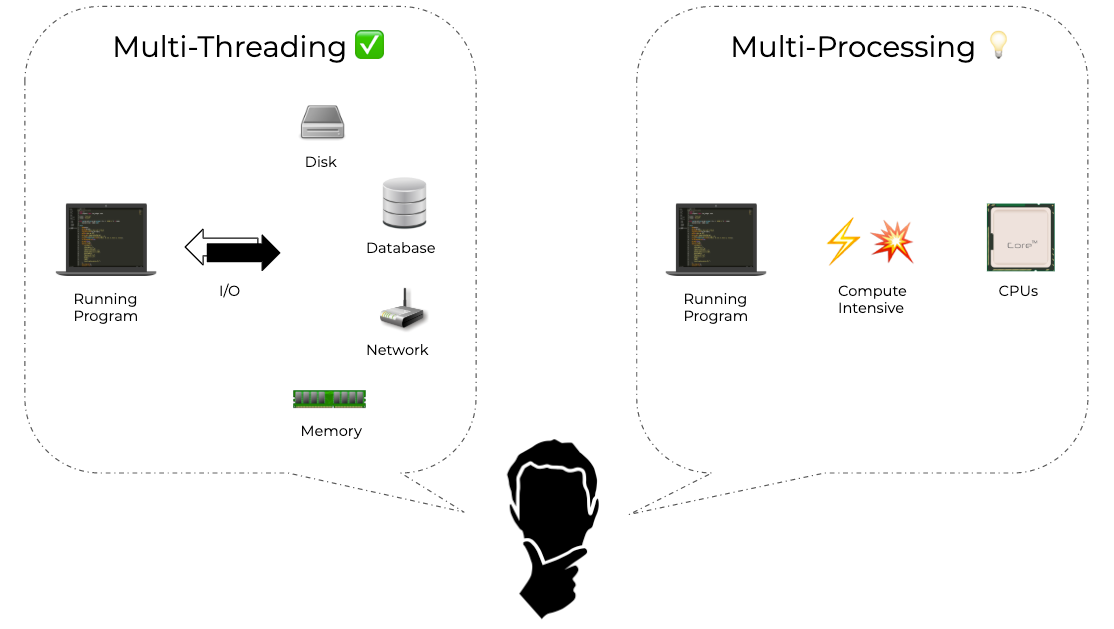

Уже давно ходит мечта об избавлении от GIL и... кажется она может исполниться:

https://www.reddit.com/r/programming/comments/15dxf6v/no_more_gil_the_python_team_has_officially/

Однако он сильно проигрывает в скорости в однопоточном сценарии (это все из-за отсутсвия типизации в питоне!):
https://www.backblaze.com/blog/python-gil-vs-nogil-boost-i-o-performance-10x-with-one-line-change/

## Попугай дня

![](https://upload.wikimedia.org/wikipedia/commons/f/f6/Naturalis_Biodiversity_Center_-_ZMA.AVES.3159_-_Conuropsis_carolinensis_Linnaeus%2C_1758_-_Psittacidae_-_skin_specimen.jpeg)

Это каролингский попугай, почти единственный попугай-эндемик США, к сожалению, вымерший в первую половину XX века. Возможно единственный ядовитый попугай (потому что при поедании его трупа все крысы и прочие погибали, связано в тем, что этот попугай ел ядовитый дурнишник)

В дикой природе он считается вымершим к началу XX века, при этом полностью вымер он только в 1918 году (в зоопарке Цинциннати оставались 2 попугая и погибли, скорее всего, из-за слишком холодной зимы).

Последнего попугая звали Инкас, причем он умер примерно в то же время, что и Марта (последний странствующий голубь). Что более всего странно, что поскольку это был последний погибший попугай, то его тело должно было быть заморожено в Смитсоновском музее. Но он потерялся и никто вообще не знает, где его тело

И вместе с Мартой эти птицы стали одним из символов угрозы вымирания животных, находящихся вокруг нас